In [4]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy
import regex as re

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [102]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    dict(name="ar", id="ex2a-1drec-andrea_withAr", guard_replace = False, unnormalise = True), 
    dict(name="noar", id="ex2b-1drec-andrea_noAr_energyimbalance", guard_replace = False, unnormalise = True), 
    dict(name="noar_rerun", id="ex2ba-mk_rerun", guard_replace = False, unnormalise = True), 
    dict(name="noar_limitFree", id="ex2ba-mk_rerun", guard_replace = False, unnormalise = True), 
]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])


Skipping unnormalisation
Skipping unnormalisation
Skipping unnormalisation
Skipping unnormalisation


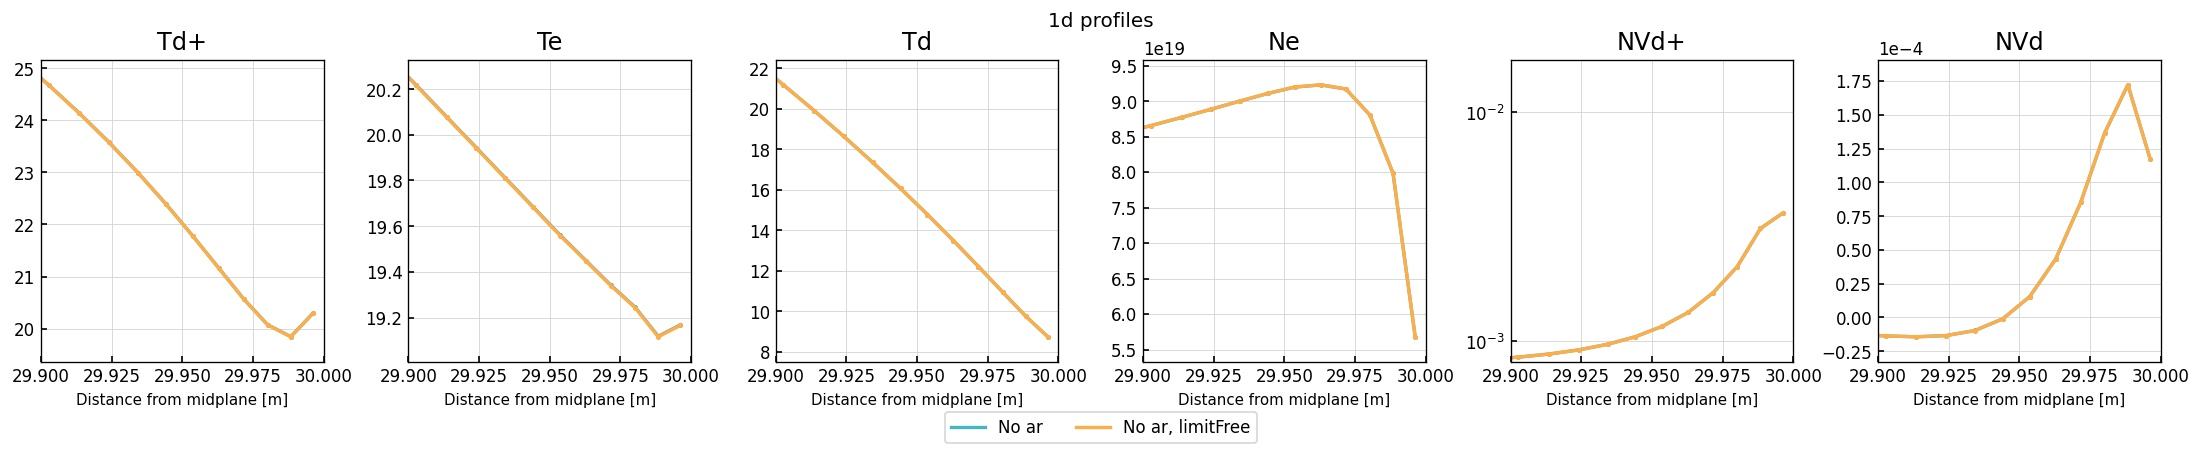

In [105]:
ds = cs["ar"].ds.isel(t=-1)

toplot = {
    "No ar" : cs["noar"].ds.isel(t=-1), 
    "No ar, limitFree" : cs["noar_limitFree"].ds.isel(t=-1), 
    # "No ar rerun" : cs["noar_rerun"].ds.isel(t=-1), 
    # "With ar" : cs["ar"].ds.isel(t=-1)
        }
lineplot(toplot, 
         params = ["Td+", "Te", "Td", "Ne", "NVd+", "NVd"],
         regions = ["1d"], xlims = (29.9,30))

Warning! Sd+_sheath not found, results may be incorrect
Warning! RAr not found, results may be incorrect
Warning! Ee_sheath not found, results may be incorrect
Warning! Ed+_sheath not found, results may be incorrect
|||WARNING: Overwriting sheath diagnostics with calculated values
Sheath diagnostics not available, attempting to reconstruct...
Ed_src is zero, dropping
RAr is zero, dropping


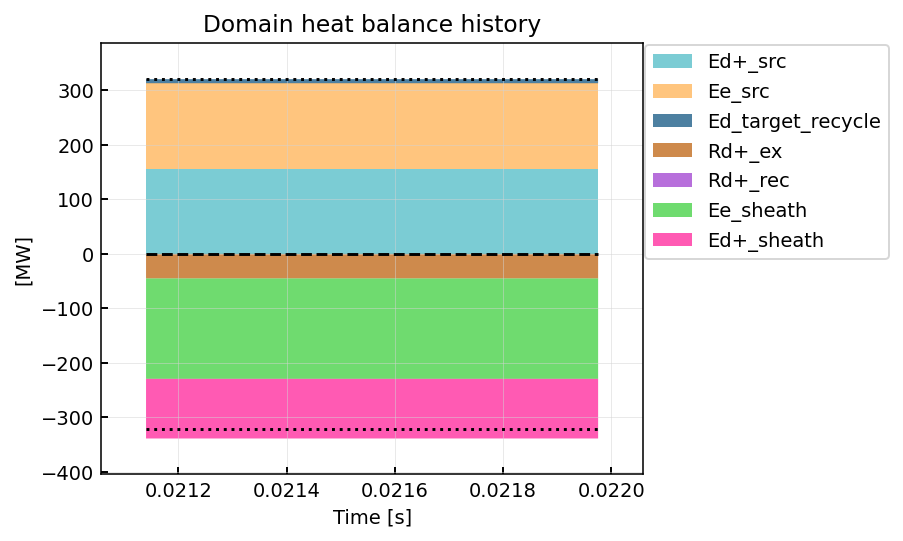

In [49]:
ds = cs["noar_rerun"].ds.isel(t=slice(5,None))
bal = Balance1D(ds)

# bal.print_balances2()

bal.get_terms()
bal.get_tallies()
bal.plot_heat_balance()

In [ ]:
ds = cs["noar"].ds.isel(t=-1)
bal = Balance1D(ds, impurity_name = "fixed_fraction_argon")

# bal.print_balances2()

bal.get_terms()
bal.get_tallies()


Warning! Sd+_sheath not found, results may be incorrect
Warning! Ee_sheath not found, results may be incorrect
Warning! Ed+_sheath not found, results may be incorrect
|||WARNING: Overwriting sheath diagnostics with calculated values
Sheath diagnostics not available, attempting to reconstruct...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [55]:
bal.pbal

{'Sd+_src': array(0.),
 'Sd_src': array(1.3318079e+25),
 'Sd+_feedback': array(-1.36380045e+20),
 'Sd+_iz': array(1.33208079e+25),
 'Sd+_rec': array(-2.72889757e+21),
 'Sd_target_recycle': array(1.3318079e+25),
 'Sd+_sheath': -1.331807896036727e+25}

In [60]:
bal.print_balances2()




Simulation geometry
    Volume: 188.49555921538757 m^3
    Area: 6.283185307179586 m^2
    Volume / area: 29.999999999999996 m

Total ion particle source:  1.3317942605860625e+25  (check: 1.3317942605860625e+25
  |- External ion source:   0.0
  |- Feedback source:       -1.363800450796952e+20
  |- Ionization source:     1.3320807883479905e+25
  |- Recombination source:  -2.7288975741999456e+21

Total neutral particle source: -2.553843687864066e+16 (check: 1.3318078934828833e+25)
  |- External neutral source:  1.3318078960367269e+25
  |- Target recycling:         1.3318078960367269e+25
  |- Ionization source:        -1.3320807883479905e+25
  |- Recombination source:     2.7288975741999456e+21

Sheath
  Density:     4.8598598334397284e+19 m^-3
  Sound speed: 43615.21033832582 m/s
  Flow speed:  43615.21055495909 m/s
  Ion sink:    -1.331807896036727e+25 s^-1
  Neutral recycling: 1.3318078960367269e+25 s^-1

Total input power:     313.27903036735154 MW
  |- Ion heating:      156.639515

(401,)


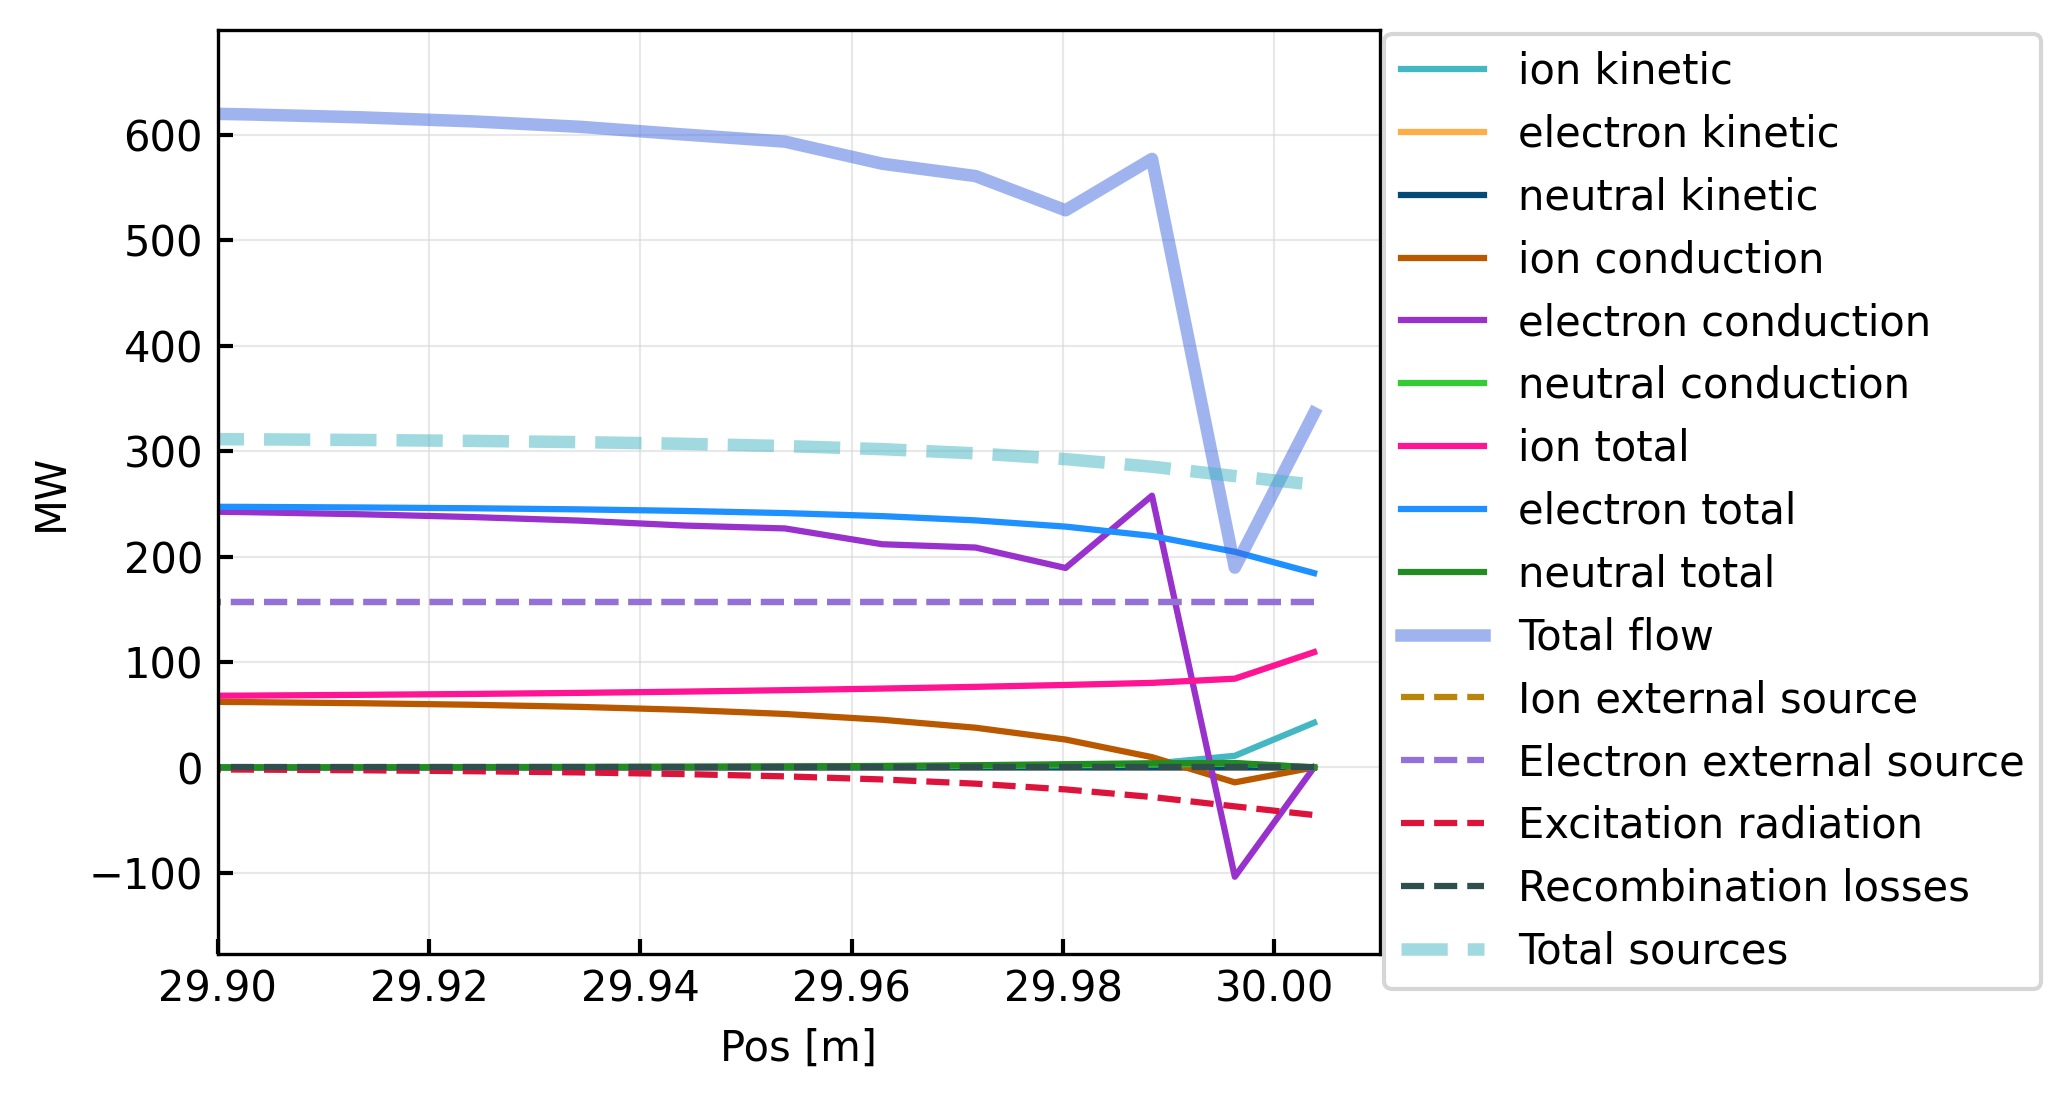

In [96]:
bal.plot_flux_balance2(xlims=(29.9,30.01))

In [89]:
flows = [
    ("efd+_kin_ylow", "ion kinetic"),
    ("efe_kin_ylow", "electron kinetic"),
    ("efd_kin_ylow", "neutral kinetic"),
    ("efd+_cond_ylow", "ion conduction"),
    ("efe_cond_ylow", "electron conduction"),
    ("efd_cond_ylow", "neutral conduction"),
    ("efd+_tot_ylow", "ion total"),
    ("efe_tot_ylow", "electron total"),
    ("efd_tot_ylow", "neutral total"),
]

# Sources of energy. To be summed along field line
sources = [
    ("Pd+_src", "Ion external source", 3./2),
    ("Pe_src", "Electron external source", 3./2),
    ("Rd+_ex", "Excitation radiation", 1.0),
    ("Rd+_rec", "Recombination losses", 1.0),
    #("Edd+_cx", "CX d -> d+", -1.0),
    #("Ed+_iz", "IZ d -> d+", 1.0),
    #("SPd+", "SPd+", 3./2),
    #("SPe", "SPe", 3./2),
]